# Supervised ML methods for anomaly detection in IOT to enahnce network security
## Part 4 - DATA TUNING - DECISION TREE

The IoT-23 dataset is a collection of network traffic from Internet of Things (IoT) devices. It includes 20 malware captures executed in IoT devices, and 3 hotspot captures for benign IoT devices traffic12. The 3 hotspot captures are not being included in the data cleaning because this feature was not considered relevant for the specific analysis being performed.

In this notebook, we load the processed dataset file and use it to tune one of the previously trained classification models.

> **INPUT:** the cleaned and processed dataset csv file. <br>
> **OUTPUT:** an analysis of the model's performance before/after tuning.

***

In [1]:
# Import necessary libraries and modules
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix, recall_score, accuracy_score, f1_score
from statistics import mean
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
import time
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option("display.float", "{:.2f}".format)

In [3]:
# Read the dataset
data_df = pd.read_csv('../CSV-data/processed/iot23_processed.csv', index_col=0)

In [4]:
# Split data into independent and dependent variables
data_X = data_df.drop("label", axis=1)
data_y = data_df["label"]
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=100)

In [5]:
# transform or normalize our data with standard scalar function
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [7]:
# Define the model
model = DecisionTreeClassifier()

# Define the oversampler and undersampler
oversampler = RandomOverSampler(sampling_strategy='minority')
undersampler = RandomUnderSampler(sampling_strategy='majority')

# Apply oversampling
X_over, y_over = oversampler.fit_resample(X_train, y_train)

# Apply undersampling
X_under, y_under = undersampler.fit_resample(X_train, y_train)

# Train and evaluate the model with oversampling
model.fit(X_over, y_over)
scores_over = cross_val_score(model, X_over, y_over, cv=5)

# Train and evaluate the model with undersampling
model.fit(X_under, y_under)
scores_under = cross_val_score(model, X_under, y_under, cv=5)

# Compare the performance
print(f'Average accuracy with oversampling: {scores_over.mean()}')
print(f'Average accuracy with undersampling: {scores_under.mean()}')

Average accuracy with oversampling: 0.999985963550348
Average accuracy with undersampling: 0.9997568830512756


In [8]:
# Count the number of instances in each class
counter = Counter(y_over)
counter = Counter(y_under)

# Print the number of instances in each class
# the number of instances in the minority class should be equal to the number of instances in the majority class.
for class_label, num_samples in counter.items():
    print(f'Class {class_label}: {num_samples} samples')

Class 0.0: 158360 samples
Class 1.0: 158360 samples


In [9]:
data_X, data_y = make_classification(n_samples=158360, random_state=1000)
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2, random_state=1000)

In [10]:
start = time.time()

# Define the model
model = DecisionTreeClassifier(random_state=1000)

# Define the parameter grid
parameters = {"criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# Initialize cross validation method
cross_validation_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000)

# Initialize tuning process
grid = GridSearchCV(
    estimator=model, 
    param_grid=parameters, 
    scoring=['accuracy','recall','precision','f1'],
    cv=cross_validation_folds,
    n_jobs=-1,
    verbose=1,
    refit='accuracy')

# Train the model
grid.fit(data_X, data_y)
best_params = grid.best_params_

print ("Best Parameters: {}".format(grid.best_params_))

end = time.time()
print('time cost: ',end - start, 'seconds')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
time cost:  363.2157332897186 seconds


In [11]:
start1 = time.time()
dt_clf = DecisionTreeClassifier(**best_params)

# Initialize the results for each classifier
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
best_f1 = -1
best_model = None

# Train the classifier
dt_clf.fit(X_train, y_train)

# Predict the test samples
y_pred = dt_clf.predict(X_test)

# Calculate and register accuracy metrics
accuracy_scores.append(accuracy_score(y_test, y_pred))
recall_scores.append(recall_score(y_test, y_pred))
precision_scores.append(precision_score(y_test, y_pred))
est_f1_score = f1_score(y_test, y_pred)
f1_scores.append(est_f1_score)

# Compare with best performing model
if best_f1 < est_f1_score:
    best_model = dt_clf
    best_f1 = est_f1_score

print_score(dt_clf, X_train, y_train, X_test, y_test, train=True)
print_score(dt_clf, X_train, y_train, X_test, y_test, train=False)

end1 = time.time()
print('time cost: ',end1 - start1, 'seconds')

Train Result:
Accuracy Score: 99.47%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     1.00     0.99      0.99       0.99          0.99
recall        0.99     1.00      0.99       0.99          0.99
f1-score      0.99     0.99      0.99       0.99          0.99
support   63442.00 63246.00      0.99  126688.00     126688.00
_______________________________________________
Confusion Matrix: 
 [[63064   378]
 [  296 62950]]

Test Result:
Accuracy Score: 99.48%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.99     1.00      0.99       0.99          0.99
recall        1.00     0.99      0.99       0.99          0.99
f1-score      0.99     0.99      0.99       0.99          0.99
support   15768.00 15904.00      0.99   31672.00      31672.00
_______________________________________________
Confusi

In [12]:
# Check and compare results and Store performance metrics
results = pd.DataFrame(index=["DT Base", "DT Tuned", "DT Trained"], columns=["Accuracy", "Recall", "Precision", "F1","Time(in sec)"])
results.iloc[0] = [0.97, 0.98, 0.98, 0.98, 28.03] # Results obtained from previous phase
results.iloc[1] = [grid.cv_results_['mean_test_accuracy'][grid.best_index_],grid.cv_results_['mean_test_recall'][grid.best_index_], grid.cv_results_['mean_test_precision'][grid.best_index_], grid.cv_results_['mean_test_f1'][grid.best_index_],(end-start)]
results.iloc[2] = [mean(accuracy_scores),mean(recall_scores),mean(precision_scores),mean(f1_scores),(end1-start1)]
results

,Accuracy,Recall,Precision,F1,Time(in sec)
DT Base,0.97,0.98,0.98,0.98,28.03
DT Tuned,0.99,0.99,0.99,0.99,363.22
DT Trained,0.99,0.99,1.00,0.99,0.44


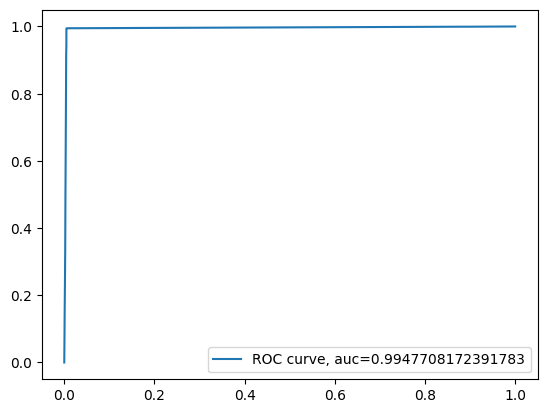

In [14]:
# Predict probabilities
y_pred_proba = dt_clf.predict_proba(X_test)[::,1]

# Compute False postive rate, and True positive rate
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

# Compute ROC AUC
roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr,tpr,label="ROC curve, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

### RESULT ANALYSIS

- DT Base: This is likely the model with default hyperparameters. It has an accuracy of 0.97, recall of 0.98, precision of 0.98, F1 score of 0.98, and it took 28.03 seconds to run.
- DT Tuned: This model probably had its hyperparameters tuned for better performance. It shows improvement across all metrics with an accuracy of 0.99, recall of 0.99, precision of 0.99, F1 score of 0.99, but it took significantly more time to run (363.22 seconds).
- DT Trained: This model might have been further trained or fine-tuned on a specific dataset. It maintains high performance with an accuracy of 0.99, recall of 0.99, perfect precision of 1.00, F1 score of 0.99, and it’s the fastest with a runtime of 0.44 seconds.
- These results indicate that tuning and training the Decision Tree model has led to significant improvements in model performance and efficiency. 
- The accuracy scores are quite high for both the training and testing sets.
- Precision, Recall, and F1-score: All approximately 0.99 for both classes.
- These results indicate that DT model is performing well on both the training and testing sets with a high degree of precision, recall, and F1-score. Hence no overfitting or underfitting.
- An AUC value of 0.9947 indicates a method is better and almost perfect ranking. A higher AUC means the model is better at distinguishing between the classes.